# Cart-Pole with Policy Gradient

In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random
from IPython.display import clear_output
from itertools import count
from logger import Logger
from pyvirtualdisplay  import Display

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

In [2]:
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [3]:
############ HYPERPARAMETERS ##############
FRAMES = 2
RESIZE_PIXELS = 60

device = 'cuda:0'

LR = 1e-5
GAMMA = 0.99
END_SCORE = 1000
############################################

In [4]:
############ ENVIRONMENT ##############

class Environment:
    def __init__(self):
        self.env = gym.make("CartPole-v0").unwrapped
        self.env.reset()
        
        screen = self.env.render(mode='rgb_array').transpose((2,0,1))
        _, self.screen_height, self.screen_width = screen.shape
        
        self.resize = T.Compose([T.ToPILImage(),
                    T.Resize(RESIZE_PIXELS, interpolation=Image.CUBIC),
                    T.Grayscale(),
                    T.ToTensor()])
        
        world_width = self.env.x_threshold * 2
        self.scale = self.screen_width / world_width
        
    def get_cart_location(self):
        return int(self.env.state[0] * self.scale + self.screen_width / 2.0)
        
    def get_screen(self):
        screen = self.env.render(mode='rgb_array').transpose((2, 0, 1))
        
        screen = screen[:, int(self.screen_height*0.4):int(self.screen_height * 0.8)]
        view_width = int(self.screen_width * 0.6)
        cart_location = self.get_cart_location()
        if cart_location < view_width // 2:
            slice_range = slice(view_width)
        elif cart_location > (self.screen_width - view_width // 2):
            slice_range = slice(-view_width, None)
        else:
            slice_range = slice(cart_location - view_width // 2,
                                cart_location + view_width // 2)
        screen = screen[:, :, slice_range]
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        return self.resize(screen).unsqueeze(0)
    
    def close(self):
        self.env.close()
        
    def step(self, action):
        return self.env.step(action)
    
    def reset(self):
        self.env.reset()

In [5]:
#### NETWORK ##############
'''
For policy gradient, the network should input the raw pixels, and output the probabilities of choosing either 0 or 1
'''

class Network(nn.Module):
    def __init__(self,h=60,w=135,device='cuda:0'):
        super().__init__()
        
        self.device = device
        
        input_channel = 2
        hidden_channel = 64
        hidden_channel2 = 32
        kernel_size = 5
        stride = 2
        
        self.base = nn.Sequential(
            nn.Conv2d(input_channel, hidden_channel, kernel_size = kernel_size, stride = stride),
            nn.BatchNorm2d(hidden_channel),
            nn.ReLU(),
            nn.Conv2d(hidden_channel, hidden_channel, kernel_size = kernel_size, stride = stride),
            nn.BatchNorm2d(hidden_channel),
            nn.ReLU(),
            nn.Conv2d(hidden_channel, hidden_channel2, kernel_size = kernel_size, stride = stride),
            nn.BatchNorm2d(hidden_channel2),
            nn.ReLU()
        )
        
        def conv2d_size_out(size, kernel_size = kernel_size, stride = stride):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * hidden_channel2
        
        self.head = nn.Sequential(
            nn.Linear(linear_input_size, 24),
            nn.ReLU(),
            nn.Linear(24, 2)
        )

    def forward(self, x):
        #x = x.to(self.device)
        x = self.base(x)
        x = x.flatten(1)
        x = self.head(x)
        return F.softmax(x,dim = 1)

In [6]:
env = Environment()

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


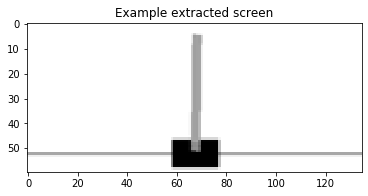

In [7]:
env.step(0)
plt.figure()
plt.imshow(env.get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy().squeeze(), cmap='gray')
plt.title('Example extracted screen')
plt.show()

In [8]:
screen_shape = env.get_screen().shape
policy_net = Network(h = screen_shape[2], w = screen_shape[3], device = device).to(device)

optimizer = optim.Adam(policy_net.parameters(), lr=LR)

In [9]:
p_screen = env.get_screen().to(device)
c_screen = env.get_screen().to(device)

x = torch.cat((p_screen, c_screen),dim=1)

policy_net(x)

tensor([[0.4649, 0.5351]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [10]:
HISTORY = []

def discount_rewards(r):
    discounted_r = torch.zeros(r.size())
    running_add = 0
    for t in reversed(range(len(r))):
        running_add = running_add * GAMMA + r[t]
        discounted_r[t] = running_add

    return discounted_r

def run_episode(net, episode, env, logger = None):
    net.eval()
    state = env.reset()
    prev_screen = env.get_screen().to(device)
    
    reward_sum = 0
    xs = torch.FloatTensor([]).to(device)
    ys = torch.FloatTensor([]).to(device)
    rewards = torch.FloatTensor([]).to(device)
    steps = 0

    for t in count():
        screen = env.get_screen().to(device)
        
        x = torch.cat((prev_screen, screen), dim=1)
        
        action_prob = net(x)

        action = 0 if random.random() < action_prob[0][0] else 1

        y = torch.FloatTensor([[1, 0]] if action == 0 else [[0, 1]]).to(device)
        
        xs = torch.cat([xs, x])
        ys = torch.cat([ys, y])
        
        prev_screen = screen
        state, reward, done, _ = env.step(action)
        
#         # Reward modification for better stability
#         x, x_dot, theta, theta_dot = state
#         r1 = (env.env.x_threshold - abs(x)) / env.env.x_threshold - 0.8
#         r2 = (env.env.theta_threshold_radians - abs(theta)) / env.env.theta_threshold_radians - 0.5
#         reward = r1 + r2
#         #reward = torch.tensor([reward], device=device)
#         if t >= END_SCORE-1:
#             reward = reward + 20
#             done = 1
#         else: 
#             if done:
#                 reward = reward - 20 
        
        rewards = torch.cat([rewards, torch.FloatTensor([[reward]]).to(device)])
        reward_sum += reward
        steps += 1
    

        if done or steps >= 1000:
            adv = discount_rewards(rewards)
            #adv = adv/(adv.std())
            adv = (adv - adv.mean())
            #adv = (adv - adv.mean())/(adv.std() + 1e-7)
            #print(adv)
            loss = learn(xs, ys, adv, net)
            #HISTORY.append(reward_sum)
            print("[Episode {:>5}]  steps: {:>5} loss: {:>5}".format(episode, steps, loss))
            #if sum(HISTORY[-100:])/100 > 980:
                #return True
            #else:
                #return False
            if logger != None:
                log.log_reward(reward=steps,episode=episode)
            return False

def learn(x, y, adv, model):
    model.train()
    # Loss function, ∑ Ai*logp(yi∣xi), but we need fake lable Y due to autodiff
    action_pred = model(x)
    y = Variable(y, requires_grad=True)
    adv = Variable(adv).to(device)
    # print(action_pred)
    log_lik = -y * torch.log(action_pred)
    # print(y)
    log_lik_adv = log_lik * adv
    # print(torch.sum(log_lik_adv, 1))
    loss = torch.sum(log_lik_adv, 1).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

In [11]:
name = f"PG hidden=64 lr={LR} max_steps=1000 Adam"
log = Logger(model_name=name)

In [15]:
import time

for episode in range(100000):
    complete = run_episode(policy_net, episode, env,log)
    print('im here')
    if complete:
        print('complete...!')
        break
    
    if episode % 50 == 0:
        clear_output(wait=True)
        torch.save(policy_net.state_dict(), f'models/{name}.pt')

[Episode   901]  steps:    22 loss: 0.010260322131216526
im here
[Episode   902]  steps:   155 loss: -1.6404759883880615
im here
[Episode   903]  steps:   125 loss: 0.18376342952251434
im here
[Episode   904]  steps:   199 loss: 0.9503225088119507
im here
[Episode   905]  steps:   123 loss: 0.387740820646286
im here
[Episode   906]  steps:   135 loss: -0.338626891374588
im here
[Episode   907]  steps:   123 loss: -0.1800611913204193
im here
[Episode   908]  steps:   159 loss: -0.7995873093605042
im here


KeyboardInterrupt: 